# How to forecast PV system power output using Neural Networks

We begin by ingesting KNMI data, this is no easy task as the KNMI database does not lend itself particularly to ease of use... After that we encode all the data to be easier to interpret by the Neural Networks. After that step we define a model, use all the functions we create along the way to slice our dataset and define our model based on hyper parameters, run that model and evaluate the output. All of this is executed inside a loop that repeats the operations for every combination of hyper-parameter values. This is repeated for 18 jobs each configured slightly differently but architecturally similar on the UU compute cluster "eejit" running CentOS Linux and SLURM cluster software. Every job is given to a single node with 96 cores, 256GB RAM and a GTX1080ti and takes approximately ~100 hours to complete.

## Ingest KNMI data

This code was written specifically for preparation of KNMI meteorological data. KNMI meteorological data comes in many smaller files each containing a few features (columns) and a cover a limited time-span. The features as measured by a multitude of meteorological sensor stations is put back-to-back into a single table. The goal is to combine the data of all features of a single station and multiple years into a single 2D time-series dataset ranging from our first measurement (00:15 1 Jan 2015) until our last measurement (00:00 1 Jan 2018) and save that in a single .csv file. This is repeated for each required collection of features.

KNMI data files contain fixed width formatted tables (ACSII tables). These tables have a predefined number of characters per column in each row of the text file. These can be read with the pandas read_fwf function. This function requires a paramter "colspecs" which should be a list that contains tuples which each contain the first and last character that makes up that column. All files that contain "neerslag" - precipitation features used as an example below have been saved with the same colspecs by KNMI, please make sure this is also the case for your dataset!

The code below is designed to be run from a separate .py file from the folder that contains the extracted KNMI data files. Multiple sanity checks have been included, each designed based around a painful mistake that was only found after hours if not days of trial and error with the model that is to make use of this data. 

In [ ]:
import pandas as pd
import os
import numpy as np
os.getcwd()

In [2]:
#Test run on a single file containing a slice of all the information we need and check our col_specs and header variables. I 
col_specs = [(0, 21), (21, 41), (41, 89), (89, 109), (109, 129), (129, 149), (149, 169), (169, 189), (189, 209), (209, 229), (229, 249)]

header = 14
file_name = 'kis_tor_'

df = pd.read_fwf(file_name + '20150131', colspecs = col_specs,
                 header = header, parse_dates = True, index_col = '# DTG')
print(len(df))
print(df.isna().sum())
print(df['NAME'].unique())
print(df.columns)

174096
LOCATION            0
NAME                0
LATITUDE            0
LONGITUDE           0
ALTITUDE            0
DR_PWS_10       78146
DR_REGENM_10    25125
WW_COR_10       67536
RI_PWS_10       80321
RI_REGENM_10    21105
dtype: int64
['Voorschoten' 'De Kooy waarneemterrein' 'Schiphol locatie 18Ct'
 'Vlieland locatie A' 'Berkhout' 'Hoorn Terschelling' 'Wijk aan Zee'
 'De Bilt locatie A' 'De Bilt testlocatie A' 'Stavoren'
 'Lelystad locatie 23t' 'Leeuwarden locatie A' 'Leeuwarden locatie obs24t'
 'Marknesse' 'Deelen locatie A' 'Deelen locatie obs02t' 'Lauwersoog'
 'Heino' 'Hoogeveen' 'Eelde locatie 23t' 'Hupsel' 'Nieuw Beerta'
 'Twenthe locatie A' 'Twenthe locatie 24t' 'Vlissingen' 'Westdorpe'
 'Wilhelminadorp' 'Hoek van Holland' 'Woensdrecht locatie A'
 'Rotterdam locatie 24t' 'Cabauw locatie A' 'Gilze-Rijen locatie 10t'
 'Herwijnen' 'Eindhoven locatie A' 'Eindhoven locatie obs22t'
 'Volkel locatie A' 'Volkel locatie obs24Rt' 'Ell'
 'Maastricht locatie 22t' 'Arcen' 'Bonaire']
Inde

In [5]:
name = 'De Bilt locatie A'

test = df.loc[df['NAME'] == name]
test = test.drop(labels = ['NAME', 'LOCATION'], axis = 1)
print(len(test))
test.isna().sum()

4464


LATITUDE          0
LONGITUDE         0
ALTITUDE          0
DR_PWS_10       215
DR_REGENM_10    201
WW_COR_10       207
RI_PWS_10       215
RI_REGENM_10    201
dtype: int64

The following loop creates a list of all the files in the working directory, creates an empty dataframe, then loops over the list with the names of each of the files in the working directory. Using string interpretation we can select only the files that start with the filename defined in code cell 2 of this chapter and print its name for sanity sake. Then we use the read_fwf function and predefined colspecs variable along with "header" which contains the number of rownumber of the column header in each of the KNMI datafiles. We select the Date column "# DTG" as our index and let the pandas date parse engine convert that into standard date-time information. I was working with data from De Bilt, therefore we want to locate the data where the entries in the "NAME" column match the name of the meteorological sensor station defined in the previous code-cell. Lets drop the "NAME" and "LOCATION" columns all together. Now lets append to our all_data dataframe that is defined outside of this loop. This loop repeats for all files that start with "file_name" contained in the working directory.

Repeat this step with custom values for the "file_name", "header", "colspecs" and "name" variables and for each collection of features.

Warning, may take hours to finish!

In [ ]:
#FOR vochtigheid&temperatuur ONLY
all_data = pd.DataFrame()
list_of_files = os.listdir(os.getcwd()) #list of files in the current directory
for each_file in list_of_files:
    if each_file.startswith(file_name):  #since its all type str you can simply use startswith
        print (each_file)
        df = pd.read_fwf(each_file, colspecs = col_specs,
                         header = header, parse_dates = True, index_col = '# DTG')
        debilt = df.loc[df['NAME'] == name]
        debilt = debilt.drop(labels = ['NAME', 'LOCATION'], axis = 1)
        all_data = all_data.append(debilt)
all_data.to_csv('2015-2017_neerslaggegevens_debilt_locatie_A.csv', sep=',')

Now we need to prepare the data for Neural network use! Simple function would've worked just as good with less code. I instead copy pasted my code for each collection of features. For each feature i drop unnecessary features and print the remaining columns as a sanity check.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
neerslag = pd.read_csv('2015-2017_neerslaggegevens_debilt_locatie_A.csv',
                      index_col = '# DTG', parse_dates = True)
neerslag = neerslag.drop(['LATITUDE', 'LONGITUDE', 'ALTITUDE'], axis = 1)
neerslag.columns

Index(['DR_PWS_10', 'DR_REGENM_10', 'WW_COR_10', 'RI_PWS_10', 'RI_REGENM_10'], dtype='object')

In [24]:
vocht_temp = pd.read_csv('2015-2017_vochtigheid_en_temperatuur_de_bilt.csv',
                        index_col = '# DTG', parse_dates = True)
vocht_temp = vocht_temp.drop(['LATITUDE', 'LONGITUDE', 'ALTITUDE'], axis = 1)
vocht_temp.columns

Index(['U_BOOL_10', 'T_DRYB_10', 'TN_10CM_PAST_6H_10', 'T_DEWP_10',
       'T_DEWP_SEA_10', 'T_DRYB_SEA_10', 'TN_DRYB_10', 'T_WETB_10',
       'TX_DRYB_10', 'U_10', 'U_SEA_10'],
      dtype='object')

In [25]:
weer_druk = pd.read_csv('2015-2017_weer_en_luchtdruk_de_bilt_testlocatie_A.csv',
                        index_col = '# DTG', parse_dates = True)
weer_druk = weer_druk.drop(['LATITUDE', 'LONGITUDE', 'ALTITUDE'], axis = 1)
weer_druk.columns

Index(['P_NAP_MSL_10', 'P_STN_LEVEL_10', 'P_SENSOR_10', 'VV_10',
       'WW_IND_CURR_10', 'WW_IND_PAST_10_10', 'WW_CURR_10', 'WW_PAST_10',
       'AH_10', 'MOR_10'],
      dtype='object')

In [26]:
wind = pd.read_csv('2015-2017_windgegevens_debilt_locatie_A.csv',
                        index_col = '# DTG', parse_dates = True)
wind = wind.drop(['LATITUDE', 'LONGITUDE', 'ALTITUDE'], axis = 1)
wind.columns

Index(['FF_10M_10', 'DD_10', 'DDN_10', 'DD_STD_10', 'DDX_10', 'FF_SENSOR_10',
       'FF_10M_STD_10', 'FX_10M_10', 'FX_10M_MD_10', 'FX_SENSOR_10',
       'FX_SENSOR_MD_10', 'SQUALL_10'],
      dtype='object')

In [27]:
zonneschijn = pd.read_csv('2015-2017_zonneschijnduur_en_straling_debilt.csv',
                        index_col = '# DTG', parse_dates = True)
zonneschijn = zonneschijn.drop(['LATITUDE', 'LONGITUDE', 'ALTITUDE'], axis = 1)
zonneschijn.columns

Index(['Q_GLOB_10', 'QN_GLOB_10', 'QX_GLOB_10', 'SQ_10'], dtype='object')

Using the pandas .join method I join the other features to the Neerslag dataframe. The join function in its current configuration will join dataframes horizontally and add index entries as required. Creating a large dataframe that contains all the features for all the years from the selected meteorological sensor station(s).

In [28]:
features = neerslag.join([vocht_temp, weer_druk, wind, zonneschijn])

For the research 1 minute and 15 minute interval data was required. This step also eliminates many "missing values" also known as "not available".

In [29]:
features_15T = features.resample('15T').mean()
features_1T = features.resample('1T').mean()

Linearly interpolating both datasets for up to a maximum of an hour's worth of missing values.

In [30]:
features_15T = features_15T.interpolate(limit = 4)
features_1T = features_1T.interpolate(limit = 60)

Dropping more features that I didn't end up needing for my final research from every dataset

In [31]:
def drop_vars(df):
    # neerslaggegevens
    df = df.drop('DR_PWS_10', axis=1)
    df = df.drop('WW_COR_10', axis=1)
    df = df.drop('RI_PWS_10', axis=1)
    df = df.drop('SQUALL_10', axis=1)
    
    # vocht & temp
    df = df.drop('T_DEWP_SEA_10', axis=1)
    df = df.drop('T_DRYB_SEA_10', axis=1)
    df = df.drop('U_SEA_10', axis=1)

    # weer & luchtdruk
    df = df.drop('P_STN_LEVEL_10', axis=1)
    df = df.drop('P_SENSOR_10', axis=1)
    df = df.drop('WW_IND_CURR_10', axis=1)
    df = df.drop('WW_IND_PAST_10_10', axis=1)
    df = df.drop('WW_CURR_10', axis=1)
    df = df.drop('WW_PAST_10', axis=1)
    
    # wind
    df = df.drop('FX_10M_10', axis=1)
    df = df.drop('FX_10M_MD_10', axis=1)
    df = df.drop('FX_SENSOR_MD_10', axis=1)
    return df

features = drop_vars(features)
features_1T = drop_vars(features_1T)
features_15T = drop_vars(features_15T)

Exporting my dataframes before doing anything else, the computation has taken long enough, no need to repeat it in case of system or programmer error.

In [32]:
features.to_csv('features.csv', sep = ',')
features_15T.to_csv('features_resample-15T_interpolate-4.csv', sep = ',')
features_1T.to_csv('features_resample-1T_interpolate-60.csv', sep = ',')

I have my PV data in separate files called "all_data_resample-1T_interpolate-60.csv" and "all_data_resample-15T_interpolate-4.csv". I will now remove the location data in those dataframes (while keeping the time-stamps) and join them to the features dataframes.

In [33]:
features_15T = pd.read_csv('features_resample-15T_interpolate-4.csv',
                       index_col = '# DTG',
                       parse_dates = True)
features_1T = pd.read_csv('features_resample-1T_interpolate-60.csv',
                       index_col = '# DTG',
                       parse_dates = True)
pv_1T = pd.read_csv('all_data_resample-1T_interpolate-60.csv', 
                    index_col = 0,
                    parse_dates = True)
pv_15T = pd.read_csv('all_data_resample-15T_interpolate-4.csv', 
                    index_col = 0,
                    parse_dates = True)

One important step is to make sure you have an entry for every single time-step between your start time and date and your end time and date. A good way to do this is to use the pandas date_range function on an empty dataframe and join your PV dataset to that empty dataframe, that way you know for sure you have an entry (even its its a missing value) for every time-step. We will be slicing the dataframe thousands of different ways, so even a single missing row can shift all the data below it by 1 time-step. And in datasets this large, if there is one entry missing, there is usually many.

In [34]:
pv_1T = pv_1T.tz_localize(None)
pv_15T = pv_15T.tz_localize(None)
all_data_1T = pv_1T.join([features_1T])
all_data_15T = pv_15T.join([features_15T])
all_data_1T.to_csv('all_data_1T.csv', sep = ',')
all_data_15T.to_csv('all_data_15T.csv', sep = ',')

## Encoding
Now we have all the required data resampled to two different temporal intervals and up to an hour's worth of consecutive missing values lineary interpolated in two separate csv files. The next step is encoding the data such that it is easy to interpret for a gradient descent algorithm.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
all_data = pd.read_csv('all_data_15T.csv',
                      index_col = 0,
                      parse_dates = True)

We want to encode each element of the date-time as a separate feature making the information less dense. (In hind-sight, this method of encoding date-time was no better than not-including date-time information whatsoever... so take it with a grain of salt.

The second function takes the sin and the cosin components of cyclical patterns, such as the direction from which the wind is coming (365 degrees) or the months of a year, days of a month, days of a week, hours of a day etc. (In hind-sight, just including the sin and cosine components of the day of the year would be much more information dense and is likely to work better than having multiple features describe the passage of time in concert).

I make a dataframe that contains the date-time information "dt_15T" using the split_df function. Then I made a second dataframe "encoded" where i stored the sin and cosin components of all the compnents of the date-time. as well as the 365 degree direction features "DD_10", "DDN_10", "DD_STD_10" and "DDX_10" which refer to different components of the wind speed.

In [3]:
def split_dt(df):
    dt = pd.DataFrame()
    dt['year'] = df.index.year
    dt['month'] = df.index.month
    dt['day'] = df.index.day
    dt['hour'] = df.index.hour
    dt['minute'] = df.index.minute
    return dt

def radial_to_features(df, target_df, feature, steps):  
    target_df[feature + '_sin'] = np.sin(df[feature]*(2.*np.pi/steps))
    target_df[feature + '_cos'] = np.cos(df[feature]*(2.*np.pi/steps))
    
dt_15T = split_dt(all_data)

encoded = pd.DataFrame()
encoded = pd.concat([encoded, pd.get_dummies(dt_15T.year, prefix = 'year')], axis = 1)
radial_to_features(dt_15T, encoded, 'month', 12)
radial_to_features(dt_15T, encoded, 'day', 31)
radial_to_features(dt_15T, encoded, 'hour', 24)
radial_to_features(dt_15T, encoded, 'minute', 60)
radials = pd.DataFrame()
radial_to_features(all_data, radials, 'DD_10', 365)
radial_to_features(all_data, radials, 'DDN_10', 365)
radial_to_features(all_data, radials, 'DD_STD_10', 365)
radial_to_features(all_data, radials, 'DDX_10', 365)


"encoded" and "radials" have no index, but should be indexed identical to the "all_data" dataframe. The radial features were originally located in between the "FF_10M" and "FF_SENSOR_10" features in the "all_data" dataframe, I wanted to put them back, but encoded in exactly the same spot to avoid confusion.

In [4]:
sensors = all_data[['151', '181', '192', '226', '262', '288', '317', '373', '380', '532']]
features1 = all_data[['DR_REGENM_10', 'RI_REGENM_10', 'U_BOOL_10', 'T_DRYB_10', 'TN_10CM_PAST_6H_10', 'T_DEWP_10', 'TN_DRYB_10', 'T_WETB_10', 
                                    'TX_DRYB_10', 'U_10', 'P_NAP_MSL_10', 'VV_10', 'AH_10', 'MOR_10', 'FF_10M_10']]
features2 = all_data[['FF_SENSOR_10', 'FF_10M_STD_10', 'FX_SENSOR_10', 'Q_GLOB_10', 'QN_GLOB_10', 'QX_GLOB_10', 'SQ_10']]
encoded.index = all_data.index
radials.index = all_data.index
features = sensors.join([encoded, features1, radials, features2])

Now our data is ready for some neural network interpretation (well.. almost)

In [5]:
features.to_csv('ML_input_1T.csv')

Checking if my encoding has worked correctly, it has!

Text(0.5, 0, 'sin')

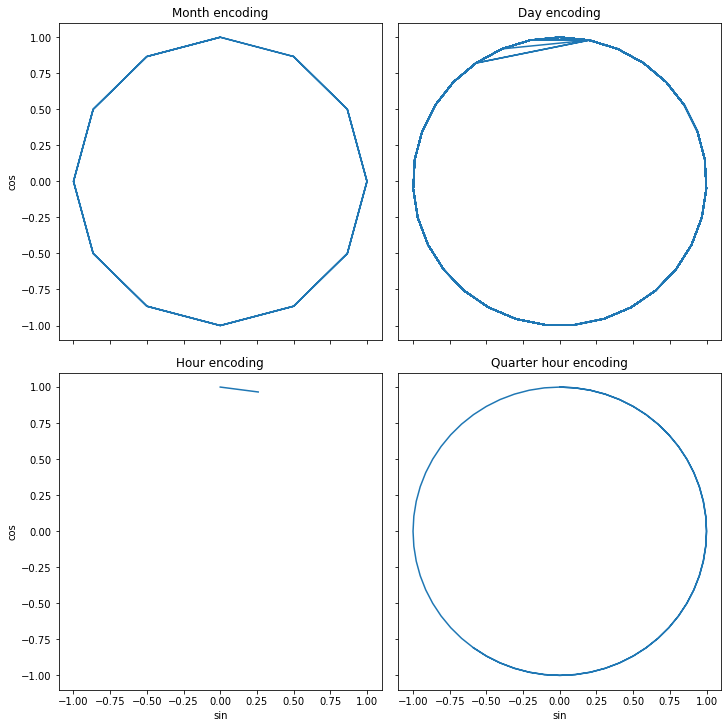

In [245]:
fig, axs = plt.subplots(2, 2,
                        sharey = True, sharex = True, 
                        constrained_layout = True,
                        figsize = (10,10))

axs[0,0].plot(encoded['month_sin'], encoded['month_cos'])
axs[0,0].set_title('Month encoding')
axs[0,0].set_ylabel('cos')

axs[0,1].plot(encoded['day_sin'], encoded['day_cos'])
axs[0,1].set_title('Day encoding')

axs[1,0].plot(encoded['hour_sin'][:97], encoded['hour_cos'][:97])
axs[1,0].set_title('Hour encoding')
axs[1,0].set_xlabel('sin')
axs[1,0].set_ylabel('cos')

axs[1,1].plot(encoded['minute_sin'][:97], encoded['minute_cos'][:97])
axs[1,1].set_title('Quarter hour encoding')
axs[1,1].set_xlabel('sin')

Text(0.5, 0, 'sin')

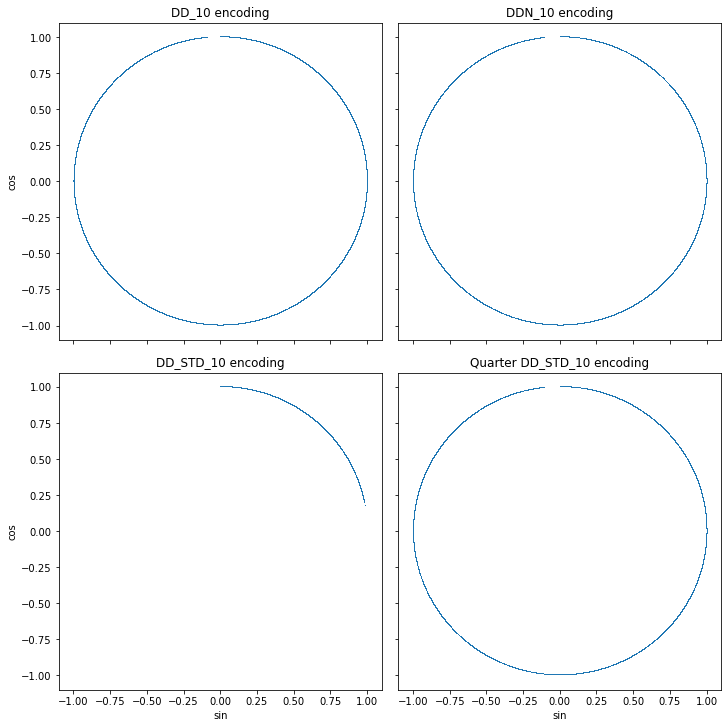

In [248]:
fig, axs = plt.subplots(2, 2,
                        sharey = True, sharex = True, 
                        constrained_layout = True,
                        figsize = (10,10))

axs[0,0].plot(radials['DD_10_sin'], radials['DD_10_cos'], ',')
axs[0,0].set_title('DD_10 encoding')
axs[0,0].set_ylabel('cos')

axs[0,1].plot(radials['DDN_10_sin'], radials['DDN_10_cos'], ',')
axs[0,1].set_title('DDN_10 encoding')

axs[1,0].plot(radials['DD_STD_10_sin'], radials['DD_STD_10_cos'], ',')
axs[1,0].set_title('DD_STD_10 encoding')
axs[1,0].set_xlabel('sin')
axs[1,0].set_ylabel('cos')

axs[1,1].plot(radials['DDX_10_sin'], radials['DDX_10_cos'], ',')
axs[1,1].set_title('Quarter DD_STD_10 encoding')
axs[1,1].set_xlabel('sin')

Its difficult to stay sane doing this work, so here are some sanity checks!

In [ ]:
def print_stats(df):
    print('df.info output:\n\n')
    print(df.info())
    print('df.describe output:\n\n')
    print(df.describe())
    print('df.isna.sum output:\n\n')
    print(df.isna().sum())
print_stats(features)
print_stats(all_data[['151', '181', '192', '226', '262', 
                     '288', '317', '373', '380', '532'
                    ]])

## DWT as features
When implementing DWT as features an additional 1T and 15T (1 minute interval and 15 minute interval) dataset is required that contains the DWT components of the selected features. This, as with the previous two steps, is done in a separate file to keep it organized, easier to error-check and faster to execute. The overall goal is to select features for which DWT decomposition could be relevant. To decompose them four times, once into 1 components, once into 2 components, once into 3 and once into 4 components. To then up-sample each column to the same length as the input, and finally to join all of the generated decompositions to the undecomposed dataset previously constructed. Now we have DWT decompositions as features in the input dataset. This is saved in a separate file mostly to speed up the training of models that do not require DWT or utilize the separate model per level of DWT approach. 

The distinct advantages of this summized: 1) greatly increased training speed, 2) better accuracy of the model. The model can be more accurate because it now has access to the source information as well as the DWT components when making a prediction and because it can relate changes in one level of DWT to changes in another. 

In [49]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt

Selecting the features for DWT decomposition and loading the dataset.

In [74]:
df = pd.read_csv('ML_input_1T.csv', index_col = 0, parse_dates = True)
df = df[['151', 'FF_10M_10', 'FF_SENSOR_10', 'FF_10M_STD_10', 'FX_SENSOR_10', 'Q_GLOB_10',
       'QN_GLOB_10', 'QX_GLOB_10', 'SQ_10']]

Decomposing the features four times each one with one more level of decomposition applied.

In [76]:
coeff_one = pywt.wavedec(df, 'haar', level = 1, axis = 0)
coeff_two = pywt.wavedec(df, 'haar', level = 2, axis = 0)
coeff_three = pywt.wavedec(df, 'haar', level = 3, axis = 0)
coeff_four = pywt.wavedec(df, 'haar', level = 4, axis = 0)

Here we see the problem that previous researchers solved by implementing multiple paralel models.

In [77]:
print(len(coeff_four[0]), len(coeff_four[1]), len(coeff_four[2]), len(coeff_four[3]), len(coeff_four[4]), len(df),  )

98640 98640 197280 394560 789120 1578240


In order to insert the correct number of "missing value" entries between each row in each 1D array that contains a level of decomposition in "coeff_one" and "coeff_two" and "coeff_three" and "coeff_four" and lining up exactly with the index in the input the pandas date_range and resample functions were abused as this allows the operation to be executed in 3 lines of code). The inserted missing values are linearly interpolated.

This results in dataframes of unequal length, as missing values are inserted after the last day of the dataset. And the number of missing values inserted varies per level of DWT. Therefore "limit" was used to discard the last day of the dataset and whatever extra missing values were appended.

The second function repeats the first function for each of the levels of DWT also identifying the "factor" variable based on length of the coefficient with regard to the  input dataframe. The "factor" variable determines how many missing values need to be inserted after each row in order to up-scale to the input temporal resolution.

In [78]:
limit = 1576800

def upsample_dwt_interpolate(arr, factor):
    frequency = str(factor) + 'ms'
    index = pd.date_range('1/1/2000', periods=len(arr), freq=frequency)
    data = pd.DataFrame(arr, index = index)
    data = data.resample('ms').asfreq()
    data = data.interpolate('linear')
    data = data.values
    data = data[:limit,:]
    return data

def upsample_dwt_levels(df, coeff):
    data = []
    for i in range(len(coeff)):
        factor = len(df) / len(coeff[i])
        upsample = upsample_dwt_interpolate(coeff[i], factor)
        data.append(upsample)
    return data

one = upsample_dwt_levels(df, coeff_one)
two = upsample_dwt_levels(df, coeff_two)
three = upsample_dwt_levels(df, coeff_three)
four = upsample_dwt_levels(df, coeff_four)

Converting numpy arrays to pandas dataframes and ensuring each column is named with a name that can be used to easily select all columns starting with the same string.

In [86]:
one_0 = pd.DataFrame(one[0], columns = df.columns).add_prefix('dwt1_0_')
one_1 = pd.DataFrame(one[1], columns = df.columns).add_prefix('dwt1_1_')
first = [one_0, one_1]
first = pd.concat(first, axis = 1)

two_0 = pd.DataFrame(two[0], columns = df.columns).add_prefix('dwt2_0_')
two_1 = pd.DataFrame(two[1], columns = df.columns).add_prefix('dwt2_1_')
two_2 = pd.DataFrame(two[2], columns = df.columns).add_prefix('dwt2_2_')
second = [two_0, two_1, two_2]
second = pd.concat(second, axis = 1)

three_0 = pd.DataFrame(three[0], columns = df.columns).add_prefix('dwt3_0_')
three_1 = pd.DataFrame(three[1], columns = df.columns).add_prefix('dwt3_1_')
three_2 = pd.DataFrame(three[2], columns = df.columns).add_prefix('dwt3_2_')
three_3 = pd.DataFrame(three[3], columns = df.columns).add_prefix('dwt3_3_')
third = [three_0, three_1, three_2, three_3]
third = pd.concat(third, axis = 1)

four_0 = pd.DataFrame(four[0], columns = df.columns).add_prefix('dwt4_0_')
four_1 = pd.DataFrame(four[1], columns = df.columns).add_prefix('dwt4_1_')
four_2 = pd.DataFrame(four[2], columns = df.columns).add_prefix('dwt4_2_')
four_3 = pd.DataFrame(four[3], columns = df.columns).add_prefix('dwt4_3_')
four_4 = pd.DataFrame(four[4], columns = df.columns).add_prefix('dwt4_4_')
fourth = [four_0, four_1, four_2, four_3, four_4]
fourth = pd.concat(fourth, axis = 1)

Concatenating the generated features to the original and making sure the limit is respected so that every value ends up associated to the correct index entry.

In [ ]:
original = pd.read_csv('ML_input_1T.csv', index_col = 0, parse_dates = True)
original_cols = original.columns
original = original[:limit].values
original = pd.DataFrame(original, columns = original_cols)
dwt = pd.concat([first, second, third, fourth], axis = 1)
dwt = pd.concat([original, dwt], axis = 1)
dwt.index = df[:limit].index

exporting in csv format to be used for modelling.

In [88]:
dwt.to_csv('ML_input_1T_dwt.csv', sep=',')

## Analyse data

Generate visualizations based on the input. The output can be seen in my Msc thesis document, this was done with too little time to spare and outside of the jupyter notebook environment, therefore the console output is not available. All of it is copied over from forums and adjusted to my needs, very little original code. Included for completion's sake.

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from scipy import stats

#%% data import



csv_path = '../Datasets/all_data/all_data.csv'
df = pd.read_csv(csv_path,
                 index_col='DateTime',
                 parse_dates=True)

index = pd.date_range(start = '2015-01-01 00:00:10+00:00', end = '2017-12-31 23:59:10+00:00', freq = '10S')
df1 = pd.DataFrame(index = index)
df1 = df1.join(df, how='left')

# generating features from the date-time-index
df1['date_time'] = df1.index

df1['year'] = df1['date_time'].apply(lambda x: x.year)
df1['quarter'] = df1['date_time'].apply(lambda x: x.quarter)
df1['month'] = df1['date_time'].apply(lambda x: x.month)
df1['day_of_month'] = df1['date_time'].apply(lambda x: x.day)
df1['hour'] = df1.index.hour
df1['minute']=df1.index.minute

df1 = df1.drop('date_time', axis=1)


#%% Data evaluation

df1.info()
df1.describe()

stat, p = stats.normaltest(df1['151'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
   print('Data looks Gaussian (fail to reject H0)')
else:
   print('Data does not look Gaussian (reject H0)')
   
plt.figure()
sns.distplot(df1['151'], hist=False, label = 'PV system power output data').set_xlim(left=0)
plt.xlabel('power output')
plt.ylabel('percentage of measurements')
plt.legend()
plt.savefig('distplot.eps')

print('Kurtosis of normal distribution: {}'.format(stats.kurtosis
                                                      (df1['151'])))
print('Skewness of normal distribution: {}'.format(stats.skew
                                                      (df1['151'])))

plt.figure(figsize=(14,5), dpi=200)
plt.subplot(1,3,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x='month', y='151', data=df1)
plt.xlabel('month')
plt.title('Box plot of monthly PV power')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,3,2)
sns.boxplot(x="hour", y='151', data=df1)
plt.xlabel('hour')
plt.title('Box plot of hourly PV power')
sns.despine(left=True)
plt.tight_layout();

plt.subplot(1,3,3)
sns.boxplot(x="quarter", y='151', data=df1)
plt.xlabel('quarter')
plt.title('Box plot of quarterly PV power')
sns.despine(left=True)
plt.tight_layout();

plt.savefig('quarterly__monthly_daily_power.png')



data = df1.copy()
data = data['151']
data = data.to_frame()
onemin = data['151'].resample('1T').mean().interpolate(method='linear', limit = 60)
onemin = onemin.to_frame()
onemin.columns = ['Frequency: 1 min']
fifteenmin = data['151'].resample('15T').mean().interpolate(method='linear', limit = 4)
fifteenmin = fifteenmin.to_frame()
fifteenmin.columns = ['Frequency: 15 min']
data.columns = ['Measurements']

fig, ax = plt.subplots(1,3, dpi = 300)
sns.heatmap(data.isnull(), cbar=False, ax = ax[0])
sns.heatmap(onemin.isnull(), cbar=False, ax = ax[1])
sns.heatmap(fifteenmin.isnull(), cbar=False, ax = ax[2])
#ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
plt.sca(ax[0])
plt.yticks(range(0,9469435,3156478), ['2015', '2016', '2017'])

plt.savefig('missing_values_heatmap.png')

#%%

csv_path = '../ML_input_15T.csv'
df = pd.read_csv(csv_path,
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format = True)
# df = df.between_time(sun_up, sun_down)

TIME_STEPS_PER_DAY = len(df.loc['1-1-2016'])

times = df.index.time
times = pd.DataFrame(times)
times = times[0].unique()

min_mean_max_power_at_time = pd.DataFrame()

for i in range(len(times)):
    time, min, mean, max = times[i], df.at_time(times[i])['151'].min(), df.at_time(times[i])['151'].mean(), df.at_time(times[i])['151'].max()
    min_mean_max_power_at_time = min_mean_max_power_at_time.append([[time, min, mean, max]])
min_mean_max_power_at_time.columns = ['time', 'min', 'mean', 'max']
min_mean_max_power_at_time = min_mean_max_power_at_time.set_index('time')
min_mean_max_power_at_time = round(min_mean_max_power_at_time, 2)
min_mean_max_power_at_time.plot(figsize = (8,4))
plt.ylabel('measured PV power [W]')

plt.axvline(x = '04:00:00')
plt.axvline(x = '19:45:00')
plt.savefig('min_mean_max_pv_power.eps')

# Modelling
Because my analysis was executed on a compute cluster, I needed separate .py files for each job on the cluster. I decided to execute 18 jobs on the cluster, one for each combination of DWT, model and forecasting horizon. I've done my best to consolidate the code from the separate files (see github) into a single coherent story, however parts may be missing. There are only very small differences between files when the same model and DWT implementation is used (and the temporal horizon is varied), therefore only code from the 30 minute ahead jobs is used. For a complete overview of all 18 .py files (jobs) visit my github.

I have published the best performing models on my github, all others have been discarded, as has the output of the compute clusters in order to save disk-space.

In [ ]:
# Libraries imported in each job:
from sys import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from time import time as time
from pathlib import Path
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *

# library obtained from: https://github.com/nii3lsh?tab=repositories needs to be in same directory as this script
import ramp_score as rs

## Import
Lets import the dataset we just created, lets discard values between 19:45 at night and 4 in the morning, almost all of them are 0 making our dataset imbalanced and unnecessarily sparse. Then some code to make sure we find out input dataset regardless of the computer this is running on. I don't know why, but it worked on the cluster only if i put infer_datetime_format to True.

We need "TIME_STEPS_PER_DAY" & "TRAIN_TEST_SPLIT" much later on in the modelling process, but since we haven't modified our dataframe yet, lets define them now. With large datasets like these, performing operations by overwriting the variable can help conserve RAM while running the program.

In [ ]:
results_path = 'dwt_features_conv_lstm_30/params_1/'
Path(results_path).mkdir(parents=True, exist_ok=True)

sun_up, sun_down = '04:00:00', '19:45:00'

# makes life easier when switching between personal and cluster environment
if platform == "win32":
    csv_path = '../../../pv_data/ML_input_1T_dwt.csv'
else:
    csv_path = '../pv_data/ML_input_1T_dwt.csv'
    
df = pd.read_csv(csv_path,
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format = True)
df = df.between_time(sun_up, sun_down)

TIME_STEPS_PER_DAY = len(df.loc['1-1-2016'])
TRAIN_TEST_SPLIT = len(df.loc['1-1-2015':'31-12-2016'])

## Normalization of the input data
Gradient descent works faster/ potentially more accurately when values fall between a range of 0 to 1. Therefore lets normalize the input data, it would be nice to retain the ability to scale a model's output back up to the original size. To do that we will use a separate scaling function for the target (feature/ dependent variable (the feature we wish to forecast)) as we do for all the other features. This way our scaling function for the target feature can be used on a 2D array with a single column (output of the model). After that we rebuild our dataframe.

In [ ]:
cols = df.columns
index = df.index

df = df.values

scaler_target = MinMaxScaler()
target = scaler_target.fit_transform(df[:,:1])

scaler_features = MinMaxScaler()
features = scaler_features.fit_transform(df[:,1:])

df = np.concatenate((target, features), axis=1)
df = pd.DataFrame(df, index = index, columns = cols)

With the DWT-separate-parallel models implementation the ability to scale the input data after using DWT arose, and therefore the following code was used instead. A function was used in order to have the ability to repeat this step thousands of times, once for each hyper-parameter combination.

In [ ]:
columns = df.columns
index = df.index
scale_all = MinMaxScaler()
df = scale_all.fit_transform(df)
df = pd.DataFrame(df, index = index, columns = columns)

def scale_df(df, cols):
    
    scaler_target = MinMaxScaler()
    target = scaler_target.fit_transform(df[:,:1])
    if len(cols) > 1:
        scaler_features = MinMaxScaler()
        features = scaler_features.fit_transform(df[:,1:])
        df = np.concatenate((target, features), axis=1)
        df = pd.DataFrame(df, columns = cols)
    else:
        df = pd.DataFrame(target, columns = cols)
    return scaler_target, df

## Functions
multivariate_data is a function that slices our 2D input data into a 3D array "data" of shape (samples, timesteps, features) and a 2D array "labels" of shape (samples, timesteps). Where the 3D array is the model's input and the 2D array is the expected output. The 3D "data" component of each sample contains a variable amount of timesteps set by "history_size", lets say 3 days worth of timesteps. For each timestep all the corresponding feature values are included. This cuts our input data in a number of samples close to the number of rows in the input dataset. This operation requires a lot of RAM as it has the capacity to be up to 10^4 larger than the initial dataset in memory use (Gigabytes).

The second function is designed to remove any samples that contain even a single missing value. As many samples use the same datapoints, this shows a great weakness of AI, not only is a lot of data required, the data needs to be very clean and complete to be useful.

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index, step):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

  return np.array(data), np.array(labels)

def remove_nan(X,Y):
    x = []
    y = []
    for sample in range(X.shape[0]):
        if np.isnan(X[sample,:,:]).any() | np.isnan(Y[sample,:]).any():
            None
        else:
            x.append(X[sample,:,:])
            y.append(Y[sample,:])
    x = np.array(x)
    y = np.array(y)
    return x, y

### Functions for DWT-separate-parallel-models implementation:
Variables written in CAPITAL LETTERS are considered hyper parameters, and have been passed through wrapping functions. The dwt function applies dwt using the 'haar' wavelet, this was intended as a hyper parameter, but shortcomings in pywt made this infeasible and using the level specified in the hyper-parameter grid. Then the scale_df function is used in a loop to scale all the levels of DWT to values between 0 and 1. This is done to enlarge the values in higher levels, as these can become exceedingly small when applied on scaled data.

(You might ask: "Why the initial scaling then?". To be honest, i forgot why, i know it had a good reason figured out through trial and error.)

The second function produces the value of TIME_STEPS_PER_DAY for each level of DWT. As each level of DWT has a lower number of time-steps (as discussed prior when building the database). The model's output is dependent upon this variable, therefore I built a function to produce the correct corresponding value for TIME_STEPS_PER_DAY for each level of DWT (in this implementation, a separate model is trained for each level of DWT, therefore a value for TIME_STEPS_PER_DAY is required).

In [ ]:
def dwt(df, WAVELET, LEVEL):
    cols = df.columns
    coeff = pywt.wavedec(df, WAVELET, level = LEVEL, axis = 0)
    dwt = []
    scalers = []
    for I in range(LEVEL + 1):
        scaler_0, coeff_0 = scale_df(coeff[I], cols)
        dwt.append(coeff_0)
        scalers.append(scaler_0)
    return scalers, dwt

def ts_per_day(coeff, TIME_STEPS_PER_DAY):
    ts = []
    ts.append(int(TIME_STEPS_PER_DAY / 2**(len(coeff)-1)))
    for i in range(1, len(coeff)):
        ts.append(int(TIME_STEPS_PER_DAY / 2**((len(coeff))-i)))
    return ts

## Ramp score
An interesting academic proposal was made by Vallance et al to utilize the Ramp score as an error metric along side the MSE and the MAE and many others. This was attempted in this research as it lends itself to testing new error metrics very well since many different models are trained and evaluated using error metrics. The conclusion of my research stated that the MSE and the Ramp score were highly correlated significantly and additionally the three different chosen values for the size of the sliding door/ window used to compute the ramp-score (see thesis) yielded basically the same results on the day-ahead no DWT implementations. Based on these results the choice was made to conserve limited resources and only compute the mean ramp score for a given forecast  using 1 value for the sliding door/ window size.

In [4]:
def mean_ramp_error(y_true, y_pred):
    ramp_results_3 = []
    for i in range(y_true.shape[0]):
        ramp_score_3 = rs.get_ramp_score(y_true[i,:], y_pred[i,:], avg_mins = 3, plot=False)
        ramp_results_3.append(ramp_score_3)
    return np.array(ramp_results_3).mean()

# The Model
The creation of a neural network model is put inside a function because it needs to be done for every combination of hyper-parameters in the hyper-parameter grid. The syntax reads as follows:

We define a sequential model, we add to that an input layer and specify what size of input matrix to expect, this is defined by the shape of our 3D "data" array, that is henceforth known as "x_train" or "x_test". 

sidebar: "x_test" is used after the model has been trained, in order to use it to forecast using input samples that the trained model has not seen before. This is to combat "overfitting" where the model learns the input dataset exactly, instead of only the patterns with predictive power.

After that layers are added to the model, the exact configuration of which can best be looked up in the keras documentation (keras.io). Every model.add method adds a layer that utilizes the output of the previous layer. Through the use of if statements and hyper-parameters (in CAPITAL LETTERS) the shape of the model is made subject to hyper-parameter values. Furthermore the neuron values in each layer are dependent upon many neurons in the preceding layer as explained in my thesis and my thesis references. But they also depend on some initial value and are subject to a bias. This is initialized and implemented in accordance with reference material cited in my master thesis in the Literature-state of the art & Method sections.

The final layer is a Dense layer, where each neuron is dependent upon the output of every neuron in the preceding layer. This is also known as the "interpretation" layer, where the output of more specialized layers such as the LSTM layer is interpreted. The values of the neurons in this final Dense layer is the output of the model, therefore it must have exactly "y_train.shape[1]" neurons. The "labels" output of our previous multivariate_data function will henceforth be known as "y_train" or "y_test". The shape of "y_train" is (samples, timesteps), the output of the model needs to be a value for each time-step in the forecasting horizon (30 time-steps for 30 minutes ahead), therefore the Dense layer at the end must have that many neurons.

The "OPEN_END" hyper parameter was not used in the end, as this turned out to be based on wrong assumptions, therefore only the value "False" was used.

The only difference between this code and the code for CNN and LSTM models is the removal of the LSTM and CNN + pooling layers as well as the dropout layers directly following those respectively.

In [ ]:
def make_model(x_train, y_train, 
               FILTERS1, KERNEL_SIZE1, PADDING1, DILATION_RATE1, 
               CONV_ACTIVATION, CONV2, POOL_SIZE1, CONV_POOL2, 
               OPEN_END, DEPTH, LSTM1, LSTM_ACTIVATION,
               DENSE_UNITS, DROPOUT, ACTIVATION2, 
               OPTIMIZER):
    initializer = keras.initializers.TruncatedNormal(mean=0., stddev=0.05)
    bias = keras.initializers.Constant(0.1)        
   
    model = Sequential()
    model.add(Input(shape = (x_train.shape[1], x_train.shape[2])))
    
    model.add(Conv1D(filters            = FILTERS1, 
                     kernel_size        = KERNEL_SIZE1, 
                     padding            = PADDING1,
                     dilation_rate      = DILATION_RATE1,
                     activation         = CONV_ACTIVATION,
                     kernel_initializer = initializer,
                     bias_initializer   = bias))
    if CONV2:
        model.add(Conv1D(filters            = FILTERS1, 
                         kernel_size        = KERNEL_SIZE1, 
                         padding            = PADDING1,
                         dilation_rate      = DILATION_RATE1,
                         activation         = CONV_ACTIVATION,
                         kernel_initializer = initializer,
                         bias_initializer   = bias))
    model.add(MaxPooling1D(pool_size        = POOL_SIZE1))
    model.add(Dropout(     rate             = DROPOUT))
    
    if CONV_POOL2:
        model.add(Conv1D(filters            = FILTERS1, 
                         kernel_size        = KERNEL_SIZE1, 
                         padding            = PADDING1,
                         dilation_rate      = DILATION_RATE1,
                         activation         = CONV_ACTIVATION,
                         kernel_initializer = initializer,
                         bias_initializer   = bias))
        if CONV2:
            model.add(Conv1D(filters            = FILTERS1, 
                             kernel_size        = KERNEL_SIZE1, 
                             padding            = PADDING1,
                             dilation_rate      = DILATION_RATE1,
                             activation         = CONV_ACTIVATION,
                             kernel_initializer = initializer,
                             bias_initializer   = bias))
        model.add(MaxPooling1D(pool_size        = POOL_SIZE1))
        model.add(Dropout(     rate             = DROPOUT))
    
    if OPEN_END:
        if DEPTH == 1:
            model.add(LSTM(units = LSTM1, return_sequences = True, bias_initializer = keras.initializers.Constant(value=0.1)))
        if DEPTH == 2:
            model.add(LSTM(units = LSTM1, return_sequences = True, bias_initializer = keras.initializers.Constant(value=0.1)))
            model.add(LSTM(units = LSTM1, return_sequences = True, bias_initializer = keras.initializers.Constant(value=0.1)))
        if DEPTH == 3:
            model.add(LSTM(units = LSTM1, return_sequences = True, bias_initializer = keras.initializers.Constant(value=0.1)))
            model.add(LSTM(units = LSTM1, return_sequences = True, bias_initializer = keras.initializers.Constant(value=0.1)))
            model.add(LSTM(units = LSTM1, return_sequences = True, bias_initializer = keras.initializers.Constant(value=0.1)))
        model.add(Flatten())
    else:
        if DEPTH == 1:
            model.add(LSTM(units = LSTM1, return_sequences = False, bias_initializer = keras.initializers.Constant(value=0.1)))
        if DEPTH == 2:
            model.add(LSTM(units = LSTM1, return_sequences = True, bias_initializer = keras.initializers.Constant(value=0.1)))
            model.add(LSTM(units = LSTM1, return_sequences = False, bias_initializer = keras.initializers.Constant(value=0.1)))
        if DEPTH == 3:
            model.add(LSTM(units = LSTM1, return_sequences = True, bias_initializer = keras.initializers.Constant(value=0.1)))
            model.add(LSTM(units = LSTM1, return_sequences = True, bias_initializer = keras.initializers.Constant(value=0.1)))
            model.add(LSTM(units = LSTM1, return_sequences = False, bias_initializer = keras.initializers.Constant(value=0.1)))
    
    model.add(Activation(LSTM_ACTIVATION))    
    model.add(Dropout(rate = DROPOUT))
    
    model.add(Dense(units               = DENSE_UNITS, 
                    activation          = ACTIVATION2,
                    kernel_initializer  = initializer,
                    bias_initializer    = bias))

    model.add(Dropout(rate              = DROPOUT))

    model.add(Dense(units               = y_train.shape[1], 
                    activation          = ACTIVATION2,
                    kernel_initializer  = initializer,
                    bias_initializer    = bias))
    
    model.compile(loss = 'mse', optimizer = keras.optimizers.Adam(learning_rate=OPTIMIZER))
    return model

# Gridsearching the hyper-parameter grid
This function combines the functionality of every preceding function to create a dataset, define a model, train that model for 150 epochs, save the best scoring model in a checkpoint file, load the best model when 150 epochs have been completed and evaluate it using x_test as model input and y_test as model output. This function and the loop that uses it differ the most from job to job, so two versions have been included, each using the 30 minute ahead forecasting horizon and CNN-LSTM model. The function returns the error metric values and input data shapes for sanity's sake. The saved checkpoint of the model is a complete copy of the trained model and can be used later for analysis.

STEP is written as a hyper parameter, but this was later neglected and set to 121. This allows the program to skip 121 timesteps between each input sample when generating x_train and y_train, so one sample and thus prediction every 121 minutes. This was done to conserve resources and because it appeared to not affect accuracy too much in preliminary testing.

### Training & evaluation function for the DWT as features & no DWT implementations

In [ ]:
def grid_search(df, col_selection, HISTORY, STEP_FACTOR,
                FILTERS1, KERNEL_SIZE1, PADDING1, DILATION_RATE1,
                CONV_ACTIVATION, CONV2, POOL_SIZE1, CONV_POOL2, 
                OPEN_END, DEPTH, LSTM1, LSTM_ACTIVATION, 
                DENSE_UNITS, DROPOUT, ACTIVATION2, 
                OPTIMIZER, counter,
                TIME_STEPS_PER_DAY = TIME_STEPS_PER_DAY, 
                TRAIN_TEST_SPLIT = TRAIN_TEST_SPLIT):
    df = df[['151'] + col_selection].values
    
    TARGET_COL = df[:,0]
    HISTORY_SIZE = TIME_STEPS_PER_DAY * HISTORY
    TARGET_SIZE = int(TIME_STEPS_PER_DAY / 2)
    STEP = 121

    x_train, y_train = multivariate_data(df, TARGET_COL, 0, TRAIN_TEST_SPLIT, HISTORY_SIZE, TARGET_SIZE, STEP)
    x_train, y_train = remove_nan(x_train, y_train)
    train_shape = x_train.shape
    
    x_test, y_test = multivariate_data(df, TARGET_COL, TRAIN_TEST_SPLIT, None, HISTORY_SIZE, TARGET_SIZE, STEP)
    x_test, y_test = remove_nan(x_test, y_test)
    test_shape = x_test.shape

    model = make_model(x_train = x_train,
                       y_train = y_train,
                       FILTERS1       = FILTERS1,
                       KERNEL_SIZE1   = KERNEL_SIZE1,
                       PADDING1       = PADDING1,
                       DILATION_RATE1 = DILATION_RATE1,
                       CONV_ACTIVATION= CONV_ACTIVATION,
                       CONV2          = CONV2,
                       POOL_SIZE1     = POOL_SIZE1,
                       CONV_POOL2     = CONV_POOL2,
                       OPEN_END       = OPEN_END,
                       DEPTH          = DEPTH,
                       LSTM1          = LSTM1,
                       LSTM_ACTIVATION= LSTM_ACTIVATION,
                       DENSE_UNITS    = DENSE_UNITS, 
                       DROPOUT        = DROPOUT, 
                       ACTIVATION2    = ACTIVATION2, 
                       OPTIMIZER      = OPTIMIZER)

    checkpoint_path = results_path + 'checkpoints/'
    Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
    checkpoint = keras.callbacks.ModelCheckpoint(filepath       = checkpoint_path + str(counter) + '_cp.h5',
                                                 save_best_only = True,
                                                 monitor        = 'val_loss')

    history = model.fit(x_train, y_train,
                        epochs          = 150, 
                        batch_size      = 24,
                        validation_data = (x_test, y_test),
                        callbacks       = [checkpoint],
                        verbose         = 0,
                        shuffle         = False)

    model = load_model(checkpoint_path + str(counter) + '_cp.h5')
    
    x_test1, y_test1 = multivariate_data(df, TARGET_COL, TRAIN_TEST_SPLIT, None, HISTORY_SIZE, TARGET_SIZE, 119)
    x_test1, y_test1 = remove_nan(x_test1, y_test1)
    
    predictions = model.predict(x_test1)
    predictions[predictions<0] = 0
    
    mse = mean_squared_error(y_test1, predictions, squared=True)
    mae = mean_absolute_error(y_test1, predictions)
    mre_3 = mean_ramp_error(y_test1, predictions)

    return mre_3, mse, mae, train_shape, test_shape

### Training & evaluation function for the DWT as features models
This does all the same things the function above does, but it trains multiple models, one for each level of DWT and reconstructs a single output using each model's output using the .wavedec function in pywt (python wavelet transform).

In [ ]:
def grid_search(df, col_selection, HISTORY, STEP_FACTOR,
                LEVEL, WAVELET,
                FILTERS1, KERNEL_SIZE1, PADDING1, DILATION_RATE1, ACTIVATION1, 
                CONV2, POOL_SIZE1, CONV_POOL2, DENSE_UNITS, DROPOUT, ACTIVATION2, 
                OPTIMIZER, counter,
                TIME_STEPS_PER_DAY = TIME_STEPS_PER_DAY, 
                TRAIN_TEST_SPLIT = TRAIN_TEST_SPLIT):
    df = df[['151'] + col_selection]
    
    df_eval = df.values
    x_eval, y_eval = multivariate_data(df_eval, df_eval[:,0], TRAIN_TEST_SPLIT, None, TIME_STEPS_PER_DAY * HISTORY, int(TIME_STEPS_PER_DAY / 2), TIME_STEPS_PER_DAY)
    x_eval, y_eval = remove_nan(x_eval, y_eval)
    
    scalers, wavelets = dwt(df, WAVELET, LEVEL)
    
    TS = ts_per_day(wavelets, TIME_STEPS_PER_DAY)
    TTsplit = ts_per_day(wavelets, TRAIN_TEST_SPLIT)
    
    
    PREDICTIONS = []
    
    coeff = 0
    for TIME_STEPS_PER_DAY in TS:

        df = wavelets[coeff].values
        
        TARGET_COL = df[:,0]
        HISTORY_SIZE = TIME_STEPS_PER_DAY * HISTORY
        TARGET_SIZE = int(TIME_STEPS_PER_DAY / 2)
        STEP = TIME_STEPS_PER_DAY
        
        
        x_train, y_train = multivariate_data(df, TARGET_COL, 0, TTsplit[coeff], HISTORY_SIZE, TARGET_SIZE, STEP)
        x_train, y_train = remove_nan(x_train, y_train)
        train_shape = x_train.shape

        x_test, y_test = multivariate_data(df, TARGET_COL, TTsplit[coeff], None, HISTORY_SIZE, TARGET_SIZE, STEP)
        x_test, y_test = remove_nan(x_test, y_test)
        test_shape = x_test.shape
        

        
        model = make_model(x_train        = x_train,
                           y_train        = y_train,
                           FILTERS1       = FILTERS1, 
                           KERNEL_SIZE1   = KERNEL_SIZE1, 
                           PADDING1       = PADDING1, 
                           DILATION_RATE1 = DILATION_RATE1, 
                           ACTIVATION1    = ACTIVATION1, 
                           CONV2          = CONV2, 
                           POOL_SIZE1     = POOL_SIZE1, 
                           CONV_POOL2     = CONV_POOL2, 
                           DENSE_UNITS    = DENSE_UNITS, 
                           DROPOUT        = DROPOUT, 
                           ACTIVATION2    = ACTIVATION2, 
                           OPTIMIZER      = OPTIMIZER)
        
        checkpoint_path = results_path + 'checkpoints/'
        Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
        checkpoint = keras.callbacks.ModelCheckpoint(filepath       = checkpoint_path + str(counter) + '_' + str(coeff) + '_cp.h5',
                                                     save_best_only = True,
                                                     monitor        = 'val_loss')

        history = model.fit(x_train, y_train,
                            epochs          = 200, 
                            batch_size      = 24,
                            validation_data = (x_test, y_test),
                            callbacks       = [checkpoint],
                            verbose         = 0,
                            shuffle         = False)

        model = load_model(checkpoint_path + str(counter) + '_' + str(coeff) + '_cp.h5')

        x_test1, y_test1 = multivariate_data(df, TARGET_COL, TTsplit[coeff], None, HISTORY_SIZE, TARGET_SIZE, TIME_STEPS_PER_DAY)
        x_test1, y_test1 = remove_nan(x_test1, y_test1)

        predictions = model.predict(x_test1)
        predictions = scalers[coeff].inverse_transform(predictions)
        PREDICTIONS.append(predictions[0:5000])
        
        coeff += 1
    
    
    predictions = pywt.waverec(PREDICTIONS, WAVELET, axis = 1)
    predictions[predictions<0] = 0

    mse = mean_squared_error(y_eval[0:5000, :], predictions, squared=True)
    mae = mean_absolute_error(y_eval[0:5000, :], predictions)
    mre_3 = mean_ramp_error(y_eval[0:5000, :], predictions)

    return mre_3, mse, mae, train_shape, test_shape, PREDICTIONS

## The hyper parameter grid
Works the same way for every job but with different hyper-parameters and hyper-parameter values. The variables "dwt1", "dwt2", "dwt3" and "dwt4" are lists of variable names based on their string syntax as described when creating the datasets. The values for the hyper parameters stem from literature research (see thesis) and the results of jobs that completed before the one shown below was completed (as explained in my thesis).

In [ ]:
dt_only = ['year_2015', 'year_2016', 'year_2017', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']
irradiance = ['Q_GLOB_10', 'QN_GLOB_10', 'QX_GLOB_10', 'SQ_10']
wind = ['FF_10M_10', 'DD_10_sin', 'DD_10_cos', 'DDN_10_sin', 'DDN_10_cos', 'DD_STD_10_sin', 'DD_STD_10_cos', 'DDX_10_sin', 'DDX_10_cos', 
        'FF_SENSOR_10', 'FF_10M_STD_10', 'FX_SENSOR_10']

dwt1 = list(df[df.columns[df.columns.str.startswith('dwt1', na=False)]].columns)
dwt2 = list(df[df.columns[df.columns.str.startswith('dwt2', na=False)]].columns)
dwt3 = list(df[df.columns[df.columns.str.startswith('dwt3', na=False)]].columns)
dwt4 = list(df[df.columns[df.columns.str.startswith('dwt4', na=False)]].columns)

parameters = {'col_selection'  : [irradiance,
                                  irradiance + dwt1,
                                  irradiance + dwt2,
                                  irradiance + dwt3,
                                  irradiance + dwt4],
              'HISTORY'        : [3,5,7],
              'STEP_FACTOR'    : [1],
              'FILTERS1'       : [64],
              'KERNEL_SIZE1'   : [5],
              'PADDING1'       : ['same'],
              'DILATION_RATE1' : [1],
              'CONV_ACTIVATION': ['relu'],
              'CONV2'          : [True],
              'POOL_SIZE1'     : [3,5],
              'CONV_POOL2'     : [True, False],
              'OPEN_END'       : [False],
              'DEPTH'          : [1,2,3],
              'LSTM1'          : [100],
              'LSTM_ACTIVATION': ['relu'],
              'DROPOUT'        : [0.2], 
              'DENSE_UNITS'    : [100],
              'ACTIVATION2'    : ['relu'],
              'OPTIMIZER'      : [0.001, 0.0005, 0.0001]
              }

param_grid = ParameterGrid(parameters)

# Bringing it all together!
The code below defines an output dataframe, output path and starts a loop over the parameter grid that contains every combination of hyper parameter values possible (a grid). A timer is started to record how long it took to train and evaluate each separate model and the grid_search function is run using values from the parameter grid. Afterwards the training time is recorded and the outputs of the model are appended to the output file. 

It is done this way to save all results after every training run. This way no combination of hyper-parameters needs to be re-tried in the event of cluster failure (we had 2 power outages a failed update a crash and my code crashed once while it was still in alpha emphasizing the need for this capability. In order to pick up where it left off before crashing the already completed entries in the parameter grid need to be skipped when defining the for loop. A crude approach is to wrap everything in the for loop in an if statement that depends on the "counter" variable.

If all is succesful a file that contains all hyper parameter values, model and input data properties, training time and error metric scores for each combination of hyper-parameters is produced.

This code differs from job to job due to the different hyper-parameters present in each job

In [ ]:
grid_results = pd.DataFrame(columns = ['counter', 'col_selection', 'HISTORY',  
                                       
                                       'FILTERS1', 'KERNEL_SIZE1', 'PADDING1', 'DILATION_RATE1', 
                                       'CONV_ACTIVATION', 'CONV2', 'POOL_SIZE1', 'CONV_POOL2',
                                       
                                       'STEP_FACTOR', 'OPEN_END', 'DEPTH', 'LSTM1', 'LSTM_ACTIVATION',
                                       
                                       'DROPOUT', 'DENSE_UNITS', 'ACTIVATION2', 
                                       
                                       'OPTIMIZER', 'mre_3', 'mse', 'mae', 'train_samples', 'test_samples', 'train_time'])

output_path = results_path + 'gridsearch_results.csv'


for dict_ in param_grid:
    start = time()
    mre_3, conv_mse, mae, train_shape, test_shape = grid_search(df, dict_['col_selection'], dict_['HISTORY'], dict_['STEP_FACTOR'], 
                                                                                 dict_['FILTERS1'], 
                                                                                 dict_['KERNEL_SIZE1'],
                                                                                 dict_['PADDING1'], 
                                                                                 dict_['DILATION_RATE1'], 
                                                                                 dict_['CONV_ACTIVATION'], 
                                                                                 dict_['CONV2'], 
                                                                                 dict_['POOL_SIZE1'], 
                                                                                 dict_['CONV_POOL2'],
                                                                                 dict_['OPEN_END'],
                                                                                 dict_['DEPTH'],
                                                                                 dict_['LSTM1'],
                                                                                 dict_['LSTM_ACTIVATION'],
                                                                                 dict_['DENSE_UNITS'],
                                                                                 dict_['DROPOUT'], 
                                                                                 dict_['ACTIVATION2'], 
                                                                                 dict_['OPTIMIZER'],
                                                                                 counter)
    train_time = round(time() - start, 2)
    grid_results = grid_results.append({'counter'    : counter, 
                                    'col_selection'  : dict_['col_selection'], 
                                    'HISTORY'        : dict_['HISTORY'], 
                                    'FILTERS1'       : dict_['FILTERS1'],
                                    'KERNEL_SIZE1'   : dict_['KERNEL_SIZE1'],
                                    'PADDING1'       : dict_['PADDING1'],
                                    'DILATION_RATE1' : dict_['DILATION_RATE1'],
                                    'CONV_ACTIVATION': dict_['CONV_ACTIVATION'],
                                    'CONV2'          : dict_['CONV2'],
                                    'POOL_SIZE1'     : dict_['POOL_SIZE1'],
                                    'CONV_POOL2'     : dict_['CONV_POOL2'],
                                    'STEP_FACTOR'    : dict_['STEP_FACTOR'], 
                                    'OPEN_END'       : dict_['OPEN_END'], 
                                    'DEPTH'          : dict_['DEPTH'], 
                                    'LSTM1'          : dict_['LSTM1'], 
                                    'LSTM_ACTIVATION': dict_['LSTM_ACTIVATION'],
                                    'DROPOUT'        : dict_['DROPOUT'], 
                                    'DENSE_UNITS'    : dict_['DENSE_UNITS'], 
                                    'ACTIVATION2'    : dict_['ACTIVATION2'], 
                                    'OPTIMIZER'      : dict_['OPTIMIZER'], 
                                    'mre_3'          : mre_3,
                                    'mse'            : conv_mse, 
                                    'mae'            : mae, 
                                    'train_samples'  : train_shape[0], 
                                    'test_samples'   : test_shape[0], 
                                    'train_time'     : str(train_time)
                                   }, ignore_index = True
                                  )
    grid_results.to_csv(output_path, sep=',')
    counter += 1
    print('Done!: ' + str(counter) + ' train_time: ' + str(train_time))

# Results analysis:
For all future sections: difficult to comment as it was done in a hurry and outside of jupyter notebook. 

In essence it takes the output file generated in the previous step and produces a pivot table for every hyper parameter value, groups them based on which hyper parameter they belong to and outputs a pretty latex .tex file, the one shown below was for the output of the DWT as features 30 minute ahead results.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


#%%

version = 'Day ahead DWT as features'

cols = {'col_selection' : 'Feature collections',
        'HISTORY' : 'History (in days)',
        'FILTERS1' : 'CNN filter layers',
        'KERNEL_SIZE1' : 'Kernel size',
        'CONV_ACTIVATION' : 'CNN activation function',
        'CONV2' : 'Second CNN kernel',
        'POOL_SIZE1' : 'MaxPooling layer size',
        'CONV_POOL2' : 'Second set of cnn+pooling layers',
        'DILATION_RATE1' : 'Dilation rate',
        'DEPTH' : 'Number of LSTM layers',
        'LSTM1' : 'LSTM history vector length',
        'ACTIVATION1' : 'LSTM v CNN activation function',
        'DROPOUT' : 'Dropout rate',
        'ACTIVATION2' : 'Dense layer activation function',
        'DENSE_UNITS' : 'Number of neurons in Dense layer',
        'OPTIMIZER' : 'Learning rate',
        'mse' : 'MSE',
        'mae' : 'MAE',
        'train_time' : 'Time required to train in seconds'
        } 

def reshape_col_names(path):
    results = pd.read_csv(path, index_col = 'counter')
    results = results.drop('Unnamed: 0', axis = 1)
    results = results.rename(columns = {'LSTM_ACTIVATION' : 'ACTIVATION1'})
    
    dt_only = ['year_2015', 'year_2016', 'year_2017', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']
    sensors = ['181', '192', '226', '262', '288', '317', '373', '380', '532']
    rain = ['DR_REGENM_10', 'RI_REGENM_10']
    temp = ['U_BOOL_10', 'T_DRYB_10', 'TN_10CM_PAST_6H_10', 'T_DEWP_10', 'TN_DRYB_10', 'T_WETB_10', 'TX_DRYB_10', 'U_10']
    pres_hum = ['P_NAP_MSL_10', 'VV_10', 'AH_10', 'MOR_10']
    wind_cols = ['FF_10M_10', 'DD_10_sin', 'DD_10_cos', 'DDN_10_sin', 'DDN_10_cos', 'DD_STD_10_sin', 'DD_STD_10_cos', 'DDX_10_sin', 'DDX_10_cos', 'FF_SENSOR_10', 
                 'FF_10M_STD_10', 'FX_SENSOR_10']
    irr_cols = ['Q_GLOB_10', 'QN_GLOB_10', 'QX_GLOB_10', 'SQ_10']
    
    csv_path = '../../pv_data/ML_input_15T_dwt.csv'
    df = pd.read_csv(csv_path,
                     index_col=0,
                     parse_dates=True,
                     infer_datetime_format = True,
                     nrows = 1)
    
    dwt1 = list(df[df.columns[df.columns.str.startswith('dwt1', na=False)]].columns)
    dwt2 = list(df[df.columns[df.columns.str.startswith('dwt2', na=False)]].columns)
    dwt3 = list(df[df.columns[df.columns.str.startswith('dwt3', na=False)]].columns)
    dwt4 = list(df[df.columns[df.columns.str.startswith('dwt4', na=False)]].columns)
    
    
    d = {'[]' : 'univariate' ,
         str(['year_2015', 'year_2016', 'year_2017', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']) : 'daytime',
         str(['181', '192', '226', '262', '288', '317', '373', '380', '532']) : 'sensors',
         str(dt_only + sensors) : 'daytime + sensors',
         str(dt_only + wind_cols + sensors) : 'daytime + wind + sensors',
         str(wind_cols + sensors) : 'wind + sensors',
         str(rain) : 'rain',
         str(temp) : 'temperature',
         str(pres_hum) : 'pressure and humidity',
         str(wind_cols) : 'wind',
         str(irr_cols) : 'irradiance',
         str(wind_cols + irr_cols) : 'wind + irradiance',
         str(dt_only + wind_cols + irr_cols) : 'daytime + wind + irradiance',
         str(dt_only + wind_cols + irr_cols + dwt1) : 'daytime + wind + irradiance + DWT level 1',
         str(dt_only + wind_cols + irr_cols + dwt2) : 'daytime + wind + irradiance + DWT level 2',
         str(dt_only + wind_cols + irr_cols + dwt3) : 'daytime + wind + irradiance + DWT level 3',
         str(dt_only + wind_cols + irr_cols + dwt4) : 'daytime + wind + irradiance + DWT level 4'
         } 
    
    corrected = results.col_selection.map(d)
    results['col_selection'] = corrected
    results = results.sort_values(by = 'mse', axis = 0)
    best_result = pd.DataFrame(results.values[0,:], index = results.columns.transpose(), columns = [path.split('/')[2]])
    return results, best_result

def make_pivot_tables(results, searched_params):
    pivot_tables = {}
    for i in searched_params:
        pivot_tables.update({i : pd.pivot_table(results, values='mse', index=[i]).sort_values(by='mse', axis=0)})
        
    if "CONV2" in pivot_tables:
        pivot_tables['CONV2'].index = pivot_tables['CONV2'].index.astype(dtype=str)
    if "CONV_POOL2" in  pivot_tables:
        pivot_tables['CONV_POOL2'].index = pivot_tables['CONV_POOL2'].index.astype(dtype=str)
        
    return pivot_tables

def analyse_results(path, params, directory, cols=cols, version = version):
    cnn, best_model = reshape_col_names(path)
    pivot_tables = pd.concat(make_pivot_tables(cnn, params))
    pivot_tables = pivot_tables.rename(index=cols)
    pivot_tables.index = pivot_tables.index.set_names(['Hyper-parameter', 'H-parameter values'])
    pivot_tables.columns = [directory]

    return pivot_tables, best_model

#%%
    
Hparam_grid = ['col_selection', 
                'HISTORY', 
                'DENSE_UNITS',
                'ACTIVATION2',
                'DROPOUT']


cnn, best_cnn = analyse_results('../day_ahead/dwt_as_features_conv/gridsearch_results.csv', 
                      Hparam_grid + ['FILTERS1', 'KERNEL_SIZE1', 'DILATION_RATE1', 'CONV2', 'POOL_SIZE1', 'CONV_POOL2'],
                      'cnn'
                      )
lstm, best_lstm = analyse_results('../day_ahead/dwt_as_features_lstm/gridsearch_results.csv', 
                      Hparam_grid + ['DEPTH', 'LSTM1'],
                      'lstm'
                      )
conv_lstm, best_conv_lstm = analyse_results('../day_ahead/dwt_as_features_conv_lstm/gridsearch_results.csv', 
                      Hparam_grid + ['DEPTH', 'LSTM1'] + ['FILTERS1', 'KERNEL_SIZE1', 'DILATION_RATE1', 'CONV2', 'POOL_SIZE1', 'CONV_POOL2'],
                      'conv lstm'
                      )

level0_index = cols.values()
Hparam_results = cnn.join([lstm, conv_lstm], how='outer')

def sorter(sub_df):
    sub_df = sub_df.sort_values(sub_df.columns[1])
    sub_df.index = sub_df.index.droplevel(0)
    return sub_df

Hparam_results = Hparam_results.groupby(level='Hyper-parameter').apply(sorter)
Hparam_results = Hparam_results.reindex(level0_index, level=0)

Hparam_results = Hparam_results.fillna('-')
Hparam_results.to_latex(version + ' Hparam.tex',
                        label = 'tab:' + version + ' Hparams',
                        caption = version + ' Hyper parameter search results as average mse per hyper parameter configuration (each option was tested against all possible values of all other parameters), note: sorted ascending by conv lstm values',
                        multirow = True)

#%%
best_day_ahead = pd.DataFrame().join([best_cnn.iloc[:,0], best_lstm.iloc[:,0], best_conv_lstm.iloc[:,0]], how = 'outer')
best_day_ahead.columns = ['conv', 'lstm', 'conv lstm']

best_day_ahead = best_day_ahead.drop(['train_samples', 'test_samples', 'PADDING1', 'OPTIMIZER', 'CONV_ACTIVATION'])
best_day_ahead = best_day_ahead.rename(index=cols)

best_day_ahead = best_day_ahead.fillna('-')
best_day_ahead.to_latex(version + ' best_model.tex',
                        caption = version + ' Results of hyperparameter search for the best performing model per archetype',
                        label = 'tab:' + version + ' best_model')

### An example of the .tex file generated by pandas using the multi-index dataframe composed of my pivot tables 

### The same table as it appears in the appendix of my Msc Thesis:
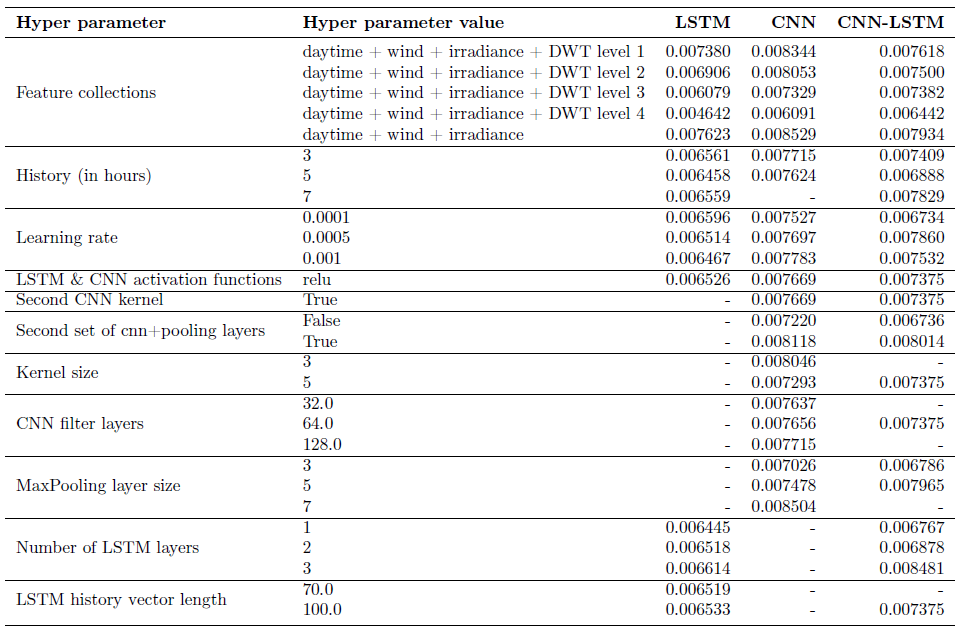

### Code used to ingest a ML_input dataset and run the best scoring model to produce predictions based on x_test and y_test:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import functions_temp as func




df = pd.read_csv('../../../pv_data/ML_input_15T_dwt.csv',
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format = True)
sun_up, sun_down = '04:00:00', '19:45:00'
df = df.between_time(sun_up, sun_down)
TIME_STEPS_PER_DAY = len(df.loc['1-1-2016'])
TRAIN_TEST_SPLIT = len(df.loc['1-1-2015':'31-12-2016'])
cols = df.columns
index = df.index
df = df.values
scaler_target = MinMaxScaler()
target = scaler_target.fit_transform(df[:,:1])
scaler_features = MinMaxScaler()
features = scaler_features.fit_transform(df[:,1:])
df = np.concatenate((target, features), axis=1)
df = pd.DataFrame(df, index = index, columns = cols)
dt_only = ['year_2015', 'year_2016', 'year_2017', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']
irradiance = ['Q_GLOB_10', 'QN_GLOB_10', 'QX_GLOB_10', 'SQ_10']
wind = ['FF_10M_10', 'DD_10_sin', 'DD_10_cos', 'DDN_10_sin', 'DDN_10_cos', 'DD_STD_10_sin', 'DD_STD_10_cos', 'DDX_10_sin', 'DDX_10_cos', 'FF_SENSOR_10', 'FF_10M_STD_10', 'FX_SENSOR_10']
dwt1 = list(df[df.columns[df.columns.str.startswith('dwt1', na=False)]].columns)
dwt2 = list(df[df.columns[df.columns.str.startswith('dwt2', na=False)]].columns)
dwt3 = list(df[df.columns[df.columns.str.startswith('dwt3', na=False)]].columns)
dwt4 = list(df[df.columns[df.columns.str.startswith('dwt4', na=False)]].columns)
df = df[['151'] + dt_only + wind + irradiance + dwt4]
cols = df.columns
df = df.values
HISTORY = 3
TARGET_COL = df[:,0]
HISTORY_SIZE = TIME_STEPS_PER_DAY * HISTORY
TARGET_SIZE = TIME_STEPS_PER_DAY
STEP = TIME_STEPS_PER_DAY
x_test1, y_test1 = func.multivariate_data(df, TARGET_COL, TRAIN_TEST_SPLIT, None, HISTORY_SIZE, TARGET_SIZE, STEP)
x_test1, y_test1 = func.remove_nan(x_test1, y_test1)


DFL = load_model('../old/dwt_as_features_lstm/1985_cp.h5')    
predictions = DFL.predict(x_test1)
predictions[predictions < 0] = 0

### The following code is the content of the "functions_temp" file imported in the previous code. 
You can really see the effect of running out of time at this point. This seemed like a logical move at the time, in hindsight not so much.

The multivariate_data and remove_nan functions are identical to the ones shown above, and are included here to be able to create samples and produce forecasts with the best models trained by the jobs on the compute cluster.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index, step):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def remove_nan(X,Y):
    x = []
    y = []
    for sample in range(X.shape[0]):
        if np.isnan(X[sample,:,:]).any() | np.isnan(Y[sample,:]).any():
            None
        else:
            x.append(X[sample,:,:])
            y.append(Y[sample,:])
    x = np.array(x)
    y = np.array(y)
    return x, y

def plot_train_test(model_input, expected_output, fig_title, fontsize, predictions = None, end_range = None):
    if end_range == None:
        end_range = model_input.shape[0]
    if hasattr(predictions, "__len__"):
        cols = 3
        FIGSIZE = (18,5)
    else:
        cols = 2
        FIGSIZE = (12,5)
        
    fig, axs = plt.subplots(1,cols, sharey = True, figsize = FIGSIZE, constrained_layout = True)
    for i in range(0, end_range):
        axs[0].plot(model_input[i,:,0])
        axs[0].set_title('PV power input', fontsize = fontsize+2)
        axs[0].set_xlabel('Timesteps, Δt = 1 minute', fontsize = fontsize)
        axs[0].set_ylabel('% maximum \nPV power output', fontsize = fontsize)
        axs[1].plot(expected_output[i,:])
        axs[1].set_title('expected output', fontsize = fontsize+2)
        axs[1].set_xlabel('Timesteps, Δt = 1 minute', fontsize = fontsize)
        if hasattr(predictions, "__len__"):
            axs[2].plot(predictions[i,:])
            axs[2].set_title('model output', fontsize = fontsize+2)
            axs[2].set_xlabel('Timesteps, Δt = 1 minute', fontsize = fontsize)
    plt.legend()
    plt.savefig(fig_title)

### Code used to produce plots of the predictions of the best scoring models. 
See thesis for detailed description and visuals. This was done under intense time-pressure, and therefore does not lend itself well for easy interpretation. However with a solid understanding of matplotlib, seaborn and pandas I'm confident any researcher that made it to this point can easily reproduce the visuals created by the code below based on the figure alone. Included for completenes's sake.

In [ ]:
fontsize = 13


# Plot measured v predicted
plt.figure(figsize=(7,5), dpi= 300)
plt.scatter(y_test1,predictions, s = 0.05, label = 'Forecast V True')
plt.scatter(y_test1,y_test1, s = 0.1, label = 'True V True')
plt.ylabel('Forecasted values \n[% maximum PV power output in test set]', fontsize = fontsize)
plt.xlabel('True values \n[% maximum PV power output in test set]', fontsize = fontsize)
plt.tight_layout()
plt.legend(markerscale = 10, fontsize = fontsize-1)
plt.savefig('TruevPred_plot.png')

# Plot prediction dataframe
fig, ax = plt.subplots(2,1, figsize = (13,7), constrained_layout = True, sharex = True)
ax1 = ax[0].imshow(y_test1.T, vmin = 0, vmax = 0.9)
ax[0].set_title('Measurements', fontsize = fontsize+2)
ax[0].set_ylabel('Timesteps, \nΔt = 15 minutes', fontsize = fontsize+1)
ax0 = ax[1].imshow(predictions.T, vmin = 0, vmax = 0.9)
ax[1].set_title('Forecasted values', fontsize = fontsize+2)
ax[1].set_xlabel('Samples (All days in 2017 for which the input and label data was complete)', fontsize = fontsize)
ax[1].set_ylabel('Timesteps, \nΔt = 15 minutes', fontsize = fontsize+1)
fig.colorbar(ax1, orientation = 'horizontal').set_label(label = '% of maximum PV power output', size = fontsize)
plt.show()
plt.savefig('TruevPred_Matrix.eps')

# Plot all input & corresponding output
import functions_temp as func
func.plot_train_test(x_test1, 
                     y_test1, 
                     fig_title = 'input_output_plot.eps', 
                     fontsize = fontsize+8, 
                     predictions = predictions)

sample = np.array([2,4,150])
func.plot_train_test(x_test1[sample], 
                     y_test1[sample], 
                     fig_title = 'input_output_plot_samples_da.eps', 
                     predictions = predictions[sample], 
                     fontsize = fontsize+8)

def plot_DWT_components(day, source_name, select_feature, var_name):
    temp = []
    for i in range(x_test1.shape[0]):
        test = pd.DataFrame(x_test1[i,:,:], columns = cols)
        temp.append(test[[source_name, dwt4[0+select_feature], dwt4[9+select_feature], dwt4[18+select_feature], dwt4[27+select_feature], dwt4[36+select_feature]]].values)
    temp = np.array(temp)
    test2 = pd.DataFrame(temp[day,:,:])
    colors = ['r','g','b','c','m', 'y']
    dwt_level = len(test2.columns)
    columns = [var_name, 'DWT level 4 approximation function', 'DWT level 4 detailed function', 'DWT level 3 detailed function', 'DWT level 2 detailed function', 'DWT level 1 detailed function',]
    fig, axs = plt.subplots(dwt_level,1, sharex = True, figsize=(12,7), tight_layout=True)
    for i in range(dwt_level):
        axs[i].plot(test2.iloc[:300,i], label=columns[i], color=colors[i])
        axs[i].set_title(columns[i], fontsize = fontsize)
    plt.xlabel('Time in minutes (5 hours total)', fontsize = fontsize+1)
    fig.savefig(var_name  + '_dwt.eps')
plot_DWT_components(100, '151', 0, 'PV power')

plt.figure()
sns.distplot(y_test1, hist=False, label='True').set_xlim(left = 0)
sns.distplot(predictions.reshape(predictions.size), hist=False, label = 'Predictions')
plt.ylabel('% values', fontsize = fontsize+1)
plt.xlabel('% maximum PV power output in test set', fontsize = fontsize+1)
plt.legend(fontsize = fontsize-1)
plt.savefig('frequency_histogram.eps')

## As far as I can tell, only the code used to generate the mean ramp score v mse graph is missing from this compilation. Every other code files varied from job to job but the essentials are all in here.